In [1]:
root_dir = "../../Downloads/GENOME540/"
read_count_path = root_dir + "chm13.chr16.txt"
scoring_scheme_path = root_dir + "dseg_score_scheme.txt"
test_read_count_path = root_dir + "test_dseg_read_count.txt"
test_scoring_scheme_path = root_dir + "test_dseg_score_scheme.txt"

In [2]:
import numpy as np

def read_rc(filename):
    return np.loadtxt(filename, usecols=(2,))

read_count = read_rc(read_count_path)

In [3]:
N_CORRECTION = 8422401 # number of Ns in chr16
ADJ_CHROM_SIZE = read_count.shape[0] - N_CORRECTION
ADJ_MEAN_COUNT = np.sum(read_count) / ADJ_CHROM_SIZE
ADJ_MEAN_COUNT

0.14936377712374954

In [4]:
from scipy.stats import poisson

# compute means of model Poisson distributions
mu_0 = ADJ_MEAN_COUNT
mu_1 = ADJ_MEAN_COUNT * 1.5

# create model Poisson distributions given N observed
x = np.arange(4)
y_0 = (poisson.pmf(mu=mu_0, k=x) * ADJ_CHROM_SIZE).astype("int64")
y_1 = (poisson.pmf(mu=mu_1, k=x) * ADJ_CHROM_SIZE).astype("int64")

print(f"X (counts):\t{x}")
print(f"Background:\t{y_0}")
print(f"Elevated CN:\t{y_1}")

X (counts):	[0 1 2 3]
Background:	[70455754 10523537   785917    39129]
Elevated CN:	[65385664 14649374  1641064   122557]


In [5]:
# compute means of model Poisson distributions
mu_0 = ADJ_MEAN_COUNT
mu_1 = ADJ_MEAN_COUNT * 1.5

# create model Poisson distributions given N observed
x = np.arange(4)
y_0 = poisson.pmf(mu=mu_0, k=x)
y_1 = poisson.pmf(mu=mu_1, k=x)

# truncate distributions
y_0[-1] += 1.0 - np.sum(y_0)
y_1[-1] += 1.0 - np.sum(y_1)

# compute LLR scoring scheme
weights = np.log2(y_1 / y_0)

print(f"X (counts):\t{x}")
print(f"Background:\t{[y.round(4) for y in y_0]}")
print(f"Elevated CN:\t{[y.round(4) for y in y_1]}")
print(f"\nWeights:\t{weights.round(4)}")

X (counts):	[0 1 2 3]
Background:	[0.8613, 0.1286, 0.0096, 0.0005]
Elevated CN:	[0.7993, 0.1791, 0.0201, 0.0016]

Weights:	[-0.1077  0.4772  1.0622  1.6748]


In [6]:
def read_score_scheme(filename):
    score_scheme = {}
    d = None
    s = None
    with open(filename, "r") as f:
        for line in f:
            line = line.split()
            if line[0] == ">=":
                score_scheme[int(line[1])] = float(line[2])
            elif line[0] == "D":
                d = float(line[1])
                s = -d
            elif line[0] == "S":
                s = float(line[1])
            else:
                score_scheme[int(line[0])] = float(line[1])

    return score_scheme, d, s

score_scheme, D, S = read_score_scheme(scoring_scheme_path)
score_scheme, D, S

({0: -0.1077, 1: 0.4772, 2: 1.0622, 3: 1.6748}, -20.0, 20.0)

In [7]:
threshold = max(score_scheme.keys())
scores = [score_scheme[threshold] if n > threshold else score_scheme[n] for n in read_count]

In [8]:
def find_dsegs(scorez, d, s):

    cumulative = maximum = start = 0
    for i in range(len(scorez)):
        cumulative += scorez[i]
        if cumulative >= maximum:
            maximum = cumulative
            end = i
        if cumulative <= 0 or cumulative <= maximum + d or i == len(scorez)-1:
            if maximum >= s:
                yield start, end, maximum
            cumulative = maximum = 0
            start = end = i + 1

In [9]:
def get_background(elevated_tuples, scorez):

    background_tuples = []

    start, _, _ = elevated_tuples[0]
    if start > 0:
        background_tuples.append((0, start - 1))

    for i in range(len(elevated_tuples) - 1):
        start, stop, _= elevated_tuples[i]
        next_start, _, _ = elevated_tuples[i + 1]

        if next_start > stop:
            background_tuples.append((stop + 1, next_start - 1))

    _, stop, _ = elevated_tuples[-1]
    if stop < len(scorez) - 1:
        background_tuples.append((stop + 1, len(scorez) - 1))

    return background_tuples

In [10]:
def get_segs(scorez, d, s):

    elevated = list(find_dsegs(scorez, d, s))
    background = get_background(elevated, scorez)

    print("Segment Histogram:")
    print("Non-Elevated CN Segments=" + str(len(background)))
    print("Elevated CN Segments=" + str(len(elevated)))

    print("\nSegment List:")
    for i in range(len(elevated)):
        print(elevated[i][0]+1, elevated[i][1]+1, f'{elevated[i][2]:.2f}')

    return background, elevated

back, elev = get_segs(scores, D, S)

Segment Histogram:
Non-Elevated CN Segments=756
Elevated CN Segments=755

Segment List:
14774 15294 24.10
16579 18935 38.10
20621 21238 28.20
21750 22121 27.81
52759 52891 22.78
458396 458684 100.39
494624 494961 91.16
818540 818893 46.46
846586 846663 32.07
857802 859275 56.69
954913 955529 28.44
1919956 1920358 40.38
2551087 2552165 37.73
2559442 2560372 26.13
3423763 3424416 23.26
4344366 4344576 37.08
4720138 4720191 26.10
4998706 4998753 21.35
5061476 5061498 24.76
5500191 5500228 39.75
6350419 6350474 29.90
6641708 6641872 23.95
8861146 8861327 22.18
9584394 9584429 33.42
9686359 9686831 23.48
11067143 11067192 21.69
11638685 11638745 20.45
11894145 11894198 22.43
11928740 11929194 23.55
14435253 14435281 24.67
14451840 14451862 25.37
14900620 14901161 20.62
14928070 14928363 25.13
15162643 15163436 42.11
15164194 15165358 21.95
15247419 15248082 20.90
15340858 15341398 32.45
16419679 16420652 46.12
16479952 16480184 34.87
16522011 16523159 33.65
16599822 16601602 65.74
16605859 

In [11]:
def display_degs(segs):
    print("Annotations:")
    sorted_segs = sorted(segs, key=lambda x: x[2], reverse=True)
    for start, end, _ in sorted_segs[:3]:
        print("\nStart:", start+1)
        print("End:", end+1)
        print("Description: ")

display_degs(elev)

Annotations:

Start: 46380682
End: 46402215
Description: 

Start: 34584619
End: 34596484
Description: 

Start: 70121519
End: 70167147
Description: 


Descriptions from UCSC genome browser --> https://genome.ucsc.edu/cgi-bin/hgGateway

Position/Search Term

chr16: 46380682-46402215 --> no annotated gene

chr16: 34584619-34596484 --> no annotated gene

chr16: 70121519-70167147 --> contains PDPR gene which encodes the pyruvate dehydrogenase phosphatase regulatory subunit) --> Pyruvate dehydrogenase complex (PDC) catalyzes the oxidative decarboxylation of pyruvate and links glycolysis to the tricarboxylic acid cycle and fatty acid synthesis. The dephosphorylation and reactivation of PDC is catalyzed by pyruvate dehydrogenase phosphatase (PDP). The dimeric PDP has a catalytic subunit and a regulatory subunit. This gene encodes the FAD-containing regulatory subunit of PDP. The encoded protein acts to decrease the sensitivity of the PDP catalytic subunit to magnesium ions. Alternative splicing results in multiple transcript variants encoding different isoforms. --> Pyruvate dehydrogenase is a complex of enzymes that is important in the conversion of pyruvate to acetyl-CoA, a key step in energy metabolism. The activity of pyruvate dehydrogenase is regulated by phosphorylation and dephosphorylation, and the PDPR protein is an important regulator of this process. The PDPR protein binds to and activates the pyruvate dehydrogenase phosphatase enzyme, which removes phosphate groups from pyruvate dehydrogenase to activate it. This allows for the efficient conversion of pyruvate to acetyl-CoA, which can then be used in the citric acid cycle to generate ATP, the main source of energy for cells. Mutations in the PDPR gene have been linked to a rare genetic disorder called pyruvate dehydrogenase phosphatase deficiency. This condition affects the activity of the pyruvate dehydrogenase complex, leading to a range of symptoms including developmental delay, muscle weakness, and seizures.

In [12]:
def read_start_hist(background, elevated):

    background_hist = [0, 0, 0, 0]
    elevated_hist = [0, 0, 0, 0]

    for i in range(len(background)):
        start, end = background[i]

        for j in range(start, end + 1):
            if read_count[j] == 0:
                background_hist[0] += 1
            elif read_count[j] == 1:
                background_hist[1] += 1
            elif read_count[j] == 2:
                background_hist[2] += 1
            else:
                background_hist[3] += 1

    for i in range(len(elevated)):
        start, end, _ = elevated[i]

        for j in range(start, end + 1):
            if read_count[j] == 0:
                elevated_hist[0] += 1
            elif read_count[j] == 1:
                elevated_hist[1] += 1
            elif read_count[j] == 2:
                elevated_hist[2] += 1
            else:
                elevated_hist[3] += 1

    print("Read start histogram for non-elevated copy-number segments:")
    print("0=" + str(background_hist[0]))
    print("1=" + str(background_hist[1]))
    print("2=" + str(background_hist[2]))
    print(">=3=" + str(background_hist[3]))

    print("\nRead start histogram for elevated copy-number segments:")
    print("0=" + str(elevated_hist[0]))
    print("1=" + str(elevated_hist[1]))
    print("2=" + str(elevated_hist[2]))
    print(">=3=" + str(elevated_hist[3]))

read_start_hist(back, elev)

Read start histogram for non-elevated copy-number segments:
0=79164784
1=8959527
2=694340
>=3=49971

Read start histogram for elevated copy-number segments:
0=1027142
1=255838
2=40942
>=3=35702


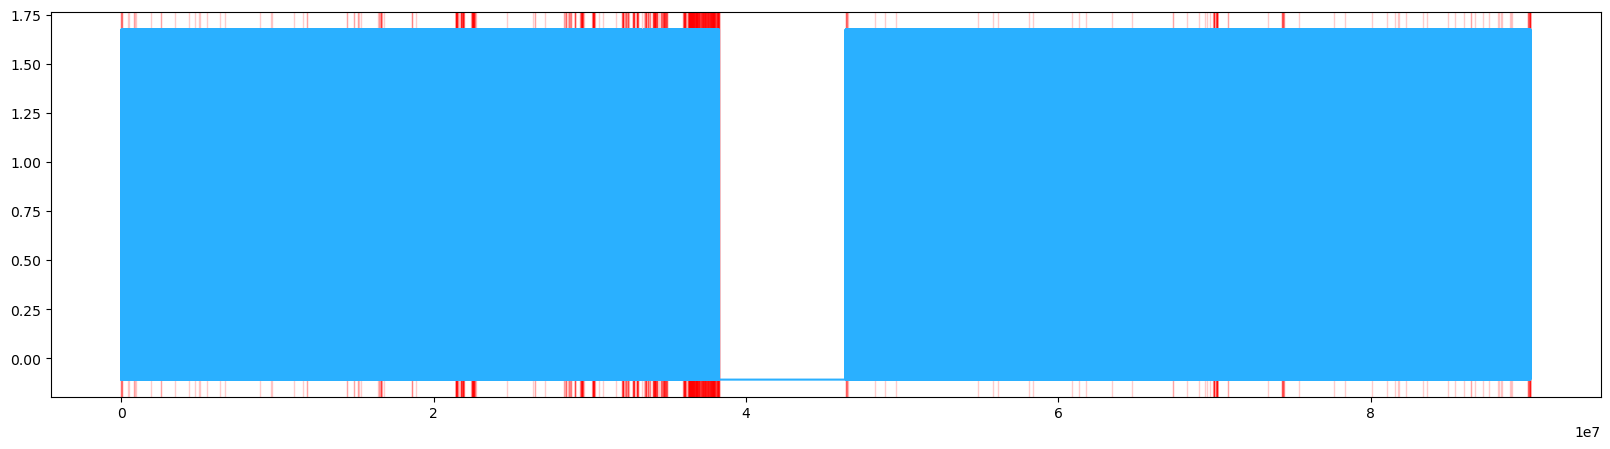

In [14]:
import matplotlib.pyplot as plt

def plot_dsegs(segs, scorez):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.plot(scorez, color='#2ab0ff')
    for start, end, _ in segs:
        ax.axvspan(start, end, alpha=0.2, color="red")
    plt.show()

plot_dsegs(elev, scores)